<a href="https://colab.research.google.com/github/ZhaoQii/IST597/blob/main/IST597_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [11]:
#np.random.seed(1178)
#tf.random.set_seed(1178)

In [4]:
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn import preprocessing
(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train_fs, y_train_fs), (X_test_fs, y_test_fs) = fashion_mnist.load_data()

# first way to normalize data
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.

X_train = X_train.reshape([X_train.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])

X_train_fs = X_train_fs.astype(float) / 255.
X_test_fs = X_test_fs.astype(float) / 255.

X_train_fs = X_train_fs.reshape([X_train_fs.shape[0], -1])
X_test_fs = X_test_fs.reshape([X_test_fs.shape[0], -1])

# one hot
onehot = preprocessing.OneHotEncoder()

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

onehot.fit(y_train)
y_train = onehot.transform(y_train).toarray()
onehot.fit(y_test)
y_test = onehot.transform(y_test).toarray()

y_train_fs = y_train_fs.reshape(-1, 1)
y_test_fs = y_test_fs.reshape(-1, 1)

onehot.fit(y_train_fs)
y_train_fs = onehot.transform(y_train_fs).toarray()
onehot.fit(y_test_fs)
y_test_fs = onehot.transform(y_test_fs).toarray()

# validation set
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]

X_train_fs, X_val_fs = X_train_fs[:-10000], X_train_fs[-10000:]
y_train_fs, y_val_fs = y_train_fs[:-10000], y_train_fs[-10000:]

4431872/4422102 [==============================] - 0s 0us/step


## Define Class

In [5]:
# Define class to build mlp model
class MLP_QZ(object):
  def __init__(self, size_data, size_input, size_hidden_1, size_hidden_2, size_output, device = None, regularizer = None,
               L1_alpha = 0., L2_alpha = 0., keep_prob_0 = 0., keep_prob_1 = 0., keep_prob_2 = 0., keep_prob_3 = 0., optimizer = 'SGD', lr = 1e-4):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_data, self.size_input, self.size_hidden_1, self.size_hidden_2, self.size_output, self.device, self.regularizer, \
    self.L1_alpha, self.L2_alpha, self.keep_prob_0, self.keep_prob_1, self.keep_prob_2, self.keep_prob_3, self.optimizer, self.lr =\
    size_data, size_input, size_hidden_1, size_hidden_2, size_output, device, regularizer, L1_alpha, L2_alpha, \
    keep_prob_0, keep_prob_1, keep_prob_2, keep_prob_3, optimizer, lr
    
    # Initialize weights between input layer and the first hidden layer
    self.W0 = tf.Variable(tf.random.normal([self.size_data, self.size_input]))
    # Initialize biases for the first hidden layer
    self.b0 = tf.Variable(tf.random.normal([1, self.size_input]))
    # Initialize weights between input layer and the first hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden_1]))
    # Initialize biases for the first hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden_1]))
    # Initialize weights between two hidden layers
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden_1, self.size_hidden_2]))
    # Initialize biases for the second hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden_2]))
     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden_2, self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W0, self.W1, self.W2, self.W3, self.b0, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    #return tf.losses.categorical_crossentropy(y_true_tf, y_pred_tf, from_logits = False)
    ce = tf.keras.losses.CategoricalCrossentropy(from_logits = True)

    if self.regularizer is None:
      return ce(y_true_tf, y_pred_tf)
    elif self.regularizer == 'L1':
      return (ce(y_true_tf, y_pred_tf) + self.L1_alpha * sum([tf.reduce_sum(tf.abs(var)) for var in self.variables]))
    elif self.regularizer == 'L2':
      return (ce(y_true_tf, y_pred_tf) + self.L2_alpha * sum([tf.nn.l2_loss(var) for var in self.variables]))
    elif self.regularizer == 'L1 + L2':
      return (ce(y_true_tf, y_pred_tf) + self.L1_alpha * sum([tf.reduce_sum(tf.abs(var)) for var in self.variables]) + self.L2_alpha * sum([tf.nn.l2_loss(var) for var in self.variables]))
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    if self.optimizer == 'SGD':
      optimizer = tf.keras.optimizers.SGD(learning_rate = self.lr)
    elif self.optimizer == 'Adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr)

    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    
    # Compute values in the first hidden layer
    what_0 = tf.matmul(X_tf, self.W0) + self.b0
    hhat_0 = tf.nn.relu(what_0)
    hhat_0 = tf.nn.dropout(hhat_0, tf.constant(self.keep_prob_0))
    # Compute values in the first hidden layer
    what_1 = tf.matmul(hhat_0, self.W1) + self.b1
    hhat_1 = tf.nn.relu(what_1)
    hhat_1 = tf.nn.dropout(hhat_1, tf.constant(self.keep_prob_1))
    # Compute values in the second hidden layer
    what_2 = tf.matmul(hhat_1, self.W2) + self.b2
    hhat_2 = tf.nn.relu(what_2)
    hhat_2 = tf.nn.dropout(hhat_2, tf.constant(self.keep_prob_2))
    # Compute output
    output = tf.matmul(hhat_2, self.W3) + self.b3
    output = tf.nn.dropout(output, tf.constant(self.keep_prob_3))
    #output = tf.nn.softmax(what_3)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

## Train Model

In [6]:
size_data, size_input, size_hidden_1, size_hidden_2, size_output = 28 * 28, 512, 512, 256, 10 
# model 3: 28 * 28, 512, 512, 256, 10 ### 1
# model 3 L2: alpha = 1 ### 2
# model 3 L1: alpha = 0.5
# model 3 L1: alpha = 0.001, adam lr 1e-3 ### 3
batch_size_train = 64
batch_size_val = 16
batch_size_test = 16

In [7]:
# Set number of epochs
NUM_EPOCHS = 5

# Initialize model
# , regularizer = 'L2', L1_alpha = 1 , regularizer = 'L2', L1_alpha = 1 , device='gpu' optimizer = 'Adam', 
mlp_on_cpu = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output) #,# regularizer = 'L2', L2_alpha = 0.5,
                    #keep_prob_0 = 0.05, keep_prob_1 = 0.05, keep_prob_2 = 0.05, keep_prob_3 = 0.05)
mlp_on_cpu_fs = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output) #,# regularizer = 'L2', L2_alpha = 0.5,
                    #keep_prob_0 = 0.05, keep_prob_1 = 0.05, keep_prob_2 = 0.05, keep_prob_3 = 0.05)

# column 0 for MINST column 1 for Fashion MNIST
train_accuracy = np.zeros([NUM_EPOCHS, 2])
val_accuracy = np.zeros([NUM_EPOCHS, 2])
train_loss = np.zeros([NUM_EPOCHS, 2])
val_loss = np.zeros([NUM_EPOCHS, 2])

time_start = time.time()
for epoch in range(NUM_EPOCHS):

  # for MNIST
  train_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  train_accuracy_epoch = tf.zeros([1,1], dtype=tf.float32)
  val_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  val_accuracy_epoch = tf.zeros([1,1], dtype=tf.float32)

  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size_train)
  val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(100).batch(batch_size_val)

  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    train_accuracy_epoch = train_accuracy_epoch + tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds, 1), tf.argmax(outputs, 1)), tf.float32))
    train_loss_epoch = train_loss_epoch + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  train_accuracy[epoch, 0] = train_accuracy_epoch / (int(X_train.shape[0] / batch_size_train) + 1)
  train_loss[epoch, 0] = train_loss_epoch / (int(X_train.shape[0] / batch_size_train) + 1)

  for inputs, outputs in val_ds:
    preds = mlp_on_cpu.forward(inputs)
    #print(tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds, 1), tf.argmax(outputs, 1)), tf.float32)))
    val_accuracy_epoch = val_accuracy_epoch + tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds, 1), tf.argmax(outputs, 1)), tf.float32))
    val_loss_epoch = val_loss_epoch + mlp_on_cpu.loss(preds, outputs)

  val_accuracy[epoch, 0] = val_accuracy_epoch / (int(X_val.shape[0] / batch_size_val) + 1)
  val_loss[epoch, 0] = val_loss_epoch / (int(X_val.shape[0] / batch_size_val) + 1)

  print('MNIST Number of Epoch = {} - Average Cross Entropy:= {} - Train acc:= {} - Val acc:= {}'.format(epoch + 1, train_loss[epoch, 0], train_accuracy[epoch, 0], val_accuracy[epoch, 0]))

  # for Fashion MNIST
  train_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  train_accuracy_epoch = tf.zeros([1,1], dtype=tf.float32)
  val_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  val_accuracy_epoch = tf.zeros([1,1], dtype=tf.float32)

  train_ds_fs = tf.data.Dataset.from_tensor_slices((X_train_fs, y_train_fs)).shuffle(100).batch(batch_size_train)
  val_ds_fs = tf.data.Dataset.from_tensor_slices((X_val_fs, y_val_fs)).shuffle(100).batch(batch_size_val)
  #train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(num_train_samples).batch(batch_size_train), seed = NUM_EPOCHS*epoch*(1178)
  
  for inputs, outputs in train_ds_fs:
    preds = mlp_on_cpu_fs.forward(inputs)
    train_accuracy_epoch = train_accuracy_epoch + tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds, 1), tf.argmax(outputs, 1)), tf.float32))
    train_loss_epoch = train_loss_epoch + mlp_on_cpu_fs.loss(preds, outputs)
    mlp_on_cpu_fs.backward(inputs, outputs)

  train_accuracy[epoch, 1] = train_accuracy_epoch / (int(X_train_fs.shape[0] / batch_size_train) + 1)
  train_loss[epoch, 1] = train_loss_epoch / (int(X_train_fs.shape[0] / batch_size_train) + 1)

  for inputs, outputs in val_ds_fs:
    preds = mlp_on_cpu_fs.forward(inputs)
    #print(tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds, 1), tf.argmax(outputs, 1)), tf.float32)))
    val_accuracy_epoch = val_accuracy_epoch + tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds, 1), tf.argmax(outputs, 1)), tf.float32))
    val_loss_epoch = val_loss_epoch + mlp_on_cpu_fs.loss(preds, outputs)
  
  val_accuracy[epoch, 1] = val_accuracy_epoch / (int(X_val_fs.shape[0] / batch_size_val) + 1)
  val_loss[epoch, 1] = val_loss_epoch / (int(X_val_fs.shape[0] / batch_size_val) + 1)

  print('Fashion MNIST Number of Epoch = {} - Average Cross Entropy:= {} - Train acc:= {} - Val acc:= {}'.format(epoch + 1, train_loss[epoch, 1], train_accuracy[epoch, 1], val_accuracy[epoch, 1]))

time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

MNIST Number of Epoch = 1 - Average Cross Entropy:= 1866.55419921875 - Train acc:= 0.8044877052307129 - Val acc:= 0.8521365523338318


KeyboardInterrupt: ignored

Text(0.5, 0, 'Epochs')

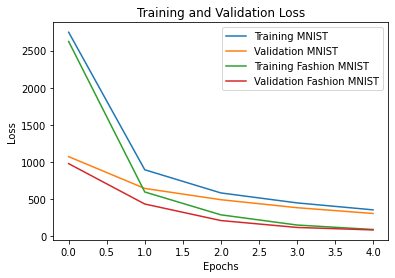

In [ ]:
plt.plot(train_loss[:, 0], label = 'Training MNIST')
plt.plot(val_loss[:, 0], label = 'Validation MNIST')
plt.plot(train_loss[:, 1], label = 'Training Fashion MNIST')
plt.plot(val_loss[:, 1], label = 'Validation Fashion MNIST')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

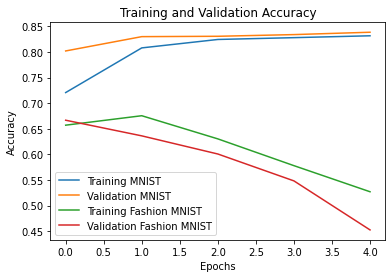

In [ ]:
plt.plot(train_accuracy[:, 0], label = 'Training MNIST')
plt.plot(val_accuracy[:, 0], label = 'Validation MNIST')
plt.plot(train_accuracy[:, 1], label = 'Training Fashion MNIST')
plt.plot(val_accuracy[:, 1], label = 'Validation Fashion MNIST')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

In [ ]:
# test sample
preds = mlp_on_cpu.forward(X_test)
test_accuracy = np.sum(preds.numpy().argmax(1) == y_test.argmax(1)) / X_test.shape[0]
preds_fs = mlp_on_cpu_fs.forward(X_test_fs)
test_accuracy_fs = np.sum(preds_fs.numpy().argmax(1) == y_test_fs.argmax(1)) / X_test_fs.shape[0]
print(test_accuracy, test_accuracy_fs)

0.8899 0.7139


## Bias vs. Variance

In [7]:
# storage
num_models = 4
num_reps = 10

test_accuracy = np.zeros([num_reps, num_models, 2])

In [8]:
###################### #1 Model 3
time_start = time.time()
for n in range(num_reps):
  print(n)
  np.random.seed(n * 631178)
  tf.random.set_seed(n * 631178)
  # Set number of epochs
  NUM_EPOCHS = 10
  # Initialize model
  mlp_on_cpu = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output)
  mlp_on_cpu_fs = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output)
  
  for epoch in range(NUM_EPOCHS):

    # for MNIST
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size_train)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(100).batch(batch_size_val)

    for inputs, outputs in train_ds:
      mlp_on_cpu.backward(inputs, outputs)

    # for Fashion MNIST
    train_ds_fs = tf.data.Dataset.from_tensor_slices((X_train_fs, y_train_fs)).shuffle(100).batch(batch_size_train)
    val_ds_fs = tf.data.Dataset.from_tensor_slices((X_val_fs, y_val_fs)).shuffle(100).batch(batch_size_val)
    
    for inputs, outputs in train_ds_fs:
      mlp_on_cpu_fs.backward(inputs, outputs)
    
  # test sample
  # for MNIST
  preds = mlp_on_cpu.forward(X_test)
  test_accuracy[n, 0, 0] = np.sum(preds.numpy().argmax(1) == y_test.argmax(1)) / X_test.shape[0]
  # for Fashion MNIST
  preds_fs = mlp_on_cpu_fs.forward(X_test_fs)
  test_accuracy[n, 0, 1] = np.sum(preds_fs.numpy().argmax(1) == y_test_fs.argmax(1)) / X_test_fs.shape[0]
  
time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

0
1
2
3
4
5
6
7
8
9

Total time taken (in seconds): 6313.02


In [21]:
test_accuracy[:, :, 1]

array([[0.669 , 0.739 , 0.7946, 0.4786],
       [0.6991, 0.7723, 0.7694, 0.5199],
       [0.7152, 0.7816, 0.7562, 0.5209],
       [0.687 , 0.7773, 0.7603, 0.4319],
       [0.7058, 0.756 , 0.754 , 0.4666],
       [0.5986, 0.7503, 0.7941, 0.398 ],
       [0.7526, 0.7133, 0.7495, 0.3095],
       [0.6859, 0.7654, 0.7257, 0.4229],
       [0.6838, 0.7286, 0.787 , 0.4256],
       [0.5794, 0.7657, 0.7662, 0.5559]])

In [ ]:
###################### #2 Model 3 L2

# column 0 for MINST column 1 for Fashion MNIST

time_start = time.time()
for n in range(num_reps):
  print(n)
  np.random.seed(n * 31178)
  tf.random.set_seed(n * 31178)
  # Set number of epochs
  NUM_EPOCHS = 5

  # Initialize model

  mlp_on_cpu = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output, regularizer = 'L2', L2_alpha = 1.)
  mlp_on_cpu_fs = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output, regularizer = 'L2', L2_alpha = 1.)

  for epoch in range(NUM_EPOCHS):

    # for MNIST
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size_train)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(100).batch(batch_size_val)

    for inputs, outputs in train_ds:
      mlp_on_cpu.backward(inputs, outputs)

    # for Fashion MNIST
    train_ds_fs = tf.data.Dataset.from_tensor_slices((X_train_fs, y_train_fs)).shuffle(100).batch(batch_size_train)
    val_ds_fs = tf.data.Dataset.from_tensor_slices((X_val_fs, y_val_fs)).shuffle(100).batch(batch_size_val)
    
    for inputs, outputs in train_ds_fs:
      mlp_on_cpu_fs.backward(inputs, outputs)
    
  # test sample
  # for MNIST
  preds = mlp_on_cpu.forward(X_test)
  test_accuracy[n, 1, 0] = np.sum(preds.numpy().argmax(1) == y_test.argmax(1)) / X_test.shape[0]
  # for Fashion MNIST
  preds_fs = mlp_on_cpu_fs.forward(X_test_fs)
  test_accuracy[n, 1, 1] = np.sum(preds_fs.numpy().argmax(1) == y_test_fs.argmax(1)) / X_test_fs.shape[0]
  
time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

In [15]:
###################### #3 Model 3 L1

# column 0 for MINST column 1 for Fashion MNIST

time_start = time.time()
for n in range(num_reps):
  print(n)
  np.random.seed(n * 1178)
  tf.random.set_seed(n * 1178)
  # Set number of epochs
  NUM_EPOCHS = 5

  # Initialize model

  mlp_on_cpu = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output, regularizer = 'L1', L1_alpha = 0.001, optimizer = 'Adam', lr = 1e-3)
  mlp_on_cpu_fs = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output, regularizer = 'L1', L1_alpha = 0.001, optimizer = 'Adam', lr = 1e-3)

  for epoch in range(NUM_EPOCHS):

    # for MNIST
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size_train)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(100).batch(batch_size_val)

    for inputs, outputs in train_ds:
      mlp_on_cpu.backward(inputs, outputs)

    # for Fashion MNIST
    train_ds_fs = tf.data.Dataset.from_tensor_slices((X_train_fs, y_train_fs)).shuffle(100).batch(batch_size_train)
    val_ds_fs = tf.data.Dataset.from_tensor_slices((X_val_fs, y_val_fs)).shuffle(100).batch(batch_size_val)
    
    for inputs, outputs in train_ds_fs:
      mlp_on_cpu_fs.backward(inputs, outputs)
    
  # test sample
  # for MNIST
  preds = mlp_on_cpu.forward(X_test)
  test_accuracy[n, 2, 0] = np.sum(preds.numpy().argmax(1) == y_test.argmax(1)) / X_test.shape[0]
  # for Fashion MNIST
  preds_fs = mlp_on_cpu_fs.forward(X_test_fs)
  test_accuracy[n, 2, 1] = np.sum(preds_fs.numpy().argmax(1) == y_test_fs.argmax(1)) / X_test_fs.shape[0]
  
time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

0
1
2
3
4
5
6
7
8
9

Total time taken (in seconds): 6361.34


In [19]:
###################### # 4 Model 3 drop

# column 0 for MINST column 1 for Fashion MNIST

time_start = time.time()
for n in range(num_reps):
  print(n)
  np.random.seed(n * 178)
  tf.random.set_seed(n * 178)
  # Set number of epochs
  NUM_EPOCHS = 5

  # Initialize model

  mlp_on_cpu = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output,
                      keep_prob_0 = 0.05, keep_prob_1 = 0.05, keep_prob_2 = 0.05, keep_prob_3 = 0.05)
  mlp_on_cpu_fs = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output,
                        keep_prob_0 = 0.05, keep_prob_1 = 0.05, keep_prob_2 = 0.05, keep_prob_3 = 0.05)

  for epoch in range(NUM_EPOCHS):

    # for MNIST
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size_train)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(100).batch(batch_size_val)

    for inputs, outputs in train_ds:
      mlp_on_cpu.backward(inputs, outputs)

    # for Fashion MNIST
    train_ds_fs = tf.data.Dataset.from_tensor_slices((X_train_fs, y_train_fs)).shuffle(100).batch(batch_size_train)
    val_ds_fs = tf.data.Dataset.from_tensor_slices((X_val_fs, y_val_fs)).shuffle(100).batch(batch_size_val)
    
    for inputs, outputs in train_ds_fs:
      mlp_on_cpu_fs.backward(inputs, outputs)
    
  # test sample
  # for MNIST
  preds = mlp_on_cpu.forward(X_test)
  test_accuracy[n, 3, 0] = np.sum(preds.numpy().argmax(1) == y_test.argmax(1)) / X_test.shape[0]
  # for Fashion MNIST
  preds_fs = mlp_on_cpu_fs.forward(X_test_fs)
  test_accuracy[n, 3, 1] = np.sum(preds_fs.numpy().argmax(1) == y_test_fs.argmax(1)) / X_test_fs.shape[0]
  
time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

0
1
2
3
4
5
6
7
8
9

Total time taken (in seconds): 3350.45


In [24]:
means_mnist = test_accuracy[:, :, 0].mean(0)
vars_mnist = test_accuracy[:, :, 0].var(0)
print(means_mnist, vars_mnist)

[0.92063 0.90666 0.87904 0.83901] [4.612410e-05 1.457840e-05 3.204824e-04 4.167490e-05]


In [25]:
means_fmnist = test_accuracy[:, :, 1].mean(0)
vars_fmnist = test_accuracy[:, :, 1].var(0)
print(means_fmnist, vars_fmnist)

[0.67764 0.75495 0.7657  0.45298] [0.00244501 0.00044417 0.00042281 0.0046234 ]


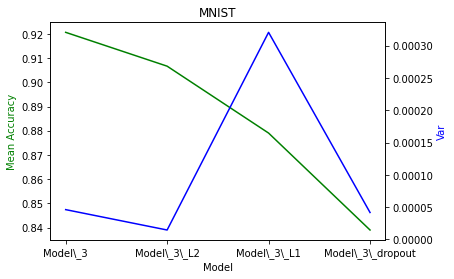

In [30]:
model_names = ['Model\_3', 'Model\_3\_L2', 'Model\_3\_L1', 'Model\_3\_dropout']
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(model_names, means_mnist, 'g-')
ax2.plot(model_names, vars_mnist, 'b-')

ax1.set_xlabel('Model')
ax1.set_ylabel('Mean Accuracy', color='g')
ax2.set_ylabel('Var', color='b')
plt.title('MNIST')
plt.show()

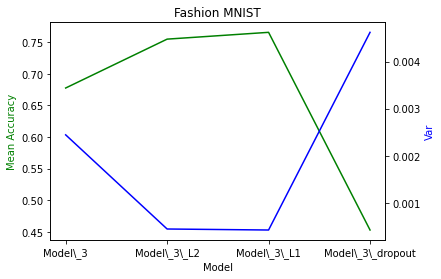

In [29]:
model_names = ['Model\_3', 'Model\_3\_L2', 'Model\_3\_L1', 'Model\_3\_dropout']
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(model_names, means_fmnist, 'g-')
ax2.plot(model_names, vars_fmnist, 'b-')

ax1.set_xlabel('Model')
ax1.set_ylabel('Mean Accuracy', color='g')
ax2.set_ylabel('Var', color='b')
plt.title('Fashion MNIST')
plt.show()